In [2]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import itertools

In [3]:
def generate_all_policies(diagram, decision_node): # get all possible strategies (policies) for a decision node
    parent_ids = diagram.parents(decision_node)
    parent_domains = [range(diagram.variable(p).domainSize()) for p in parent_ids]
    decision_domain = range(diagram.variable(decision_node).domainSize())

    policies = []
    for mapping in itertools.product(decision_domain, repeat=int(pow(len(decision_domain), len(parent_ids)))):
        policy = {}
        for parents_values, decision_value in zip(itertools.product(*parent_domains), mapping):
            policy[parents_values] = decision_value
        policies.append(policy)
    return policies

def get_node_domain_sizes(diagram):
    return {n: diagram.variable(n).domainSize() for n in diagram.nodes() if not diagram.isUtilityNode(n)}

def generate_all_assignments(diagram):
    domain_sizes = get_node_domain_sizes(diagram)

    var_ids = list(domain_sizes.keys())
    var_domains = [range(domain_sizes[n]) for n in var_ids]

    all_combinations = itertools.product(*var_domains)

    all_assignments = []
    for combo in all_combinations:
        assignment = {}
        for i in range(len(var_ids)):
            assignment[var_ids[i]] = combo[i]
        all_assignments.append(assignment)

    return all_assignments

def get_parents_values(diagram, node, assignment):
    return tuple(assignment[p] for p in diagram.parents(node))

def assignment_respects_policy(assignment, decision_node, policy, diagram):
    parent_values = get_parents_values(diagram, decision_node, assignment)
    return assignment[decision_node] == policy[parent_values]

def compute_joint_prob(diagram, assignment):
    prob = 1.0
    for node in [n for n in diagram.nodes() if diagram.isChanceNode(n)]:
        parent_values = get_parents_values(diagram, node, assignment)
        var_value = assignment[node]
        prob *= diagram.cpt(node)[parent_values][var_value]
    return prob

def compute_total_utility(diagram, assignment):
    total = 0.0
    for node in [n for n in diagram.nodes() if diagram.isUtilityNode(n)]:
        parent_values = get_parents_values(diagram, node, assignment)
        total += diagram.utility(node)[parent_values]
    return total

def compute_meu(id): # for just ids with one decision node (for now)
    decision_nodes = [node for node in id.nodes() if id.isDecisionNode(node)]
    if len(decision_nodes) != 1:
        return
    
    meu = float('-inf')
    best_policy = None
    
    d = decision_nodes[0]
    policies = generate_all_policies(id, d)

    for policy in policies:
        eu = 0
        assignments = generate_all_assignments(id)
        for a in assignments:
            if assignment_respects_policy(a, d, policy, id):
                prob = compute_joint_prob(id, a)
                util = compute_total_utility(id, a)
                eu += prob * util
        if eu > meu:
            meu = eu
            best_policy = policy
    return meu[0], best_policy

In [4]:
id = gum.InfluenceDiagram()

rain = id.addChanceNode(gum.LabelizedVariable("Rain", 'rain', ['No', 'Yes']))
umbrella = id.addDecisionNode(gum.LabelizedVariable("Umbrella", 'umbrella', ['Take', 'Dont take']))
utility = id.addUtilityNode(gum.LabelizedVariable("am i happy", 'am i tho', 1))

id.cpt(rain)[{'Rain':'No'}] = 0.7
id.cpt(rain)[{'Rain':'Yes'}] = 0.3

id.addArc(rain, umbrella)
id.addArc(rain, utility)
id.addArc(umbrella, utility)

u = id.utility(utility)
u[{'Rain':'No', 'Umbrella':'Dont take'}] = 10
u[{'Rain':'No', 'Umbrella':'Take'}] = 7   
u[{'Rain':'Yes', 'Umbrella':'Dont take'}] = -10000   
u[{'Rain':'Yes', 'Umbrella':'Take'}] = 9

In [5]:
meu, policy = compute_meu(id)
print("MEU:", meu)
print("Best Policy:", policy)

MEU: 9.3
Best Policy: {(0,): 1, (1,): 0}


In [6]:
ewe = gum.ShaferShenoyLIMIDInference(id) 
ewe.makeInference()
print(ewe.MEU())
print(ewe.optimalDecision(umbrella))

{'mean': 9.7, 'variance': 0.21000000000000796}

      ||  Umbrella         |
Rain  ||Take     |Dont take|
------||---------|---------|
No    || 0.0000  | 1.0000  |
Yes   || 1.0000  | 0.0000  |



In [7]:
pigs = gum.InfluenceDiagram()
pigs.loadBIFXML('pigs_limid.bifxml')

True

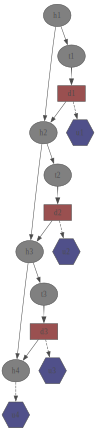

In [8]:
gnb.showInfluenceDiagram(pigs)

In [23]:
test_id = gum.InfluenceDiagram()

for i in range(1, 7):
    test_id.addChanceNode(gum.LabelizedVariable(f'C{i}'))
for i in range(1, 4):
    test_id.addDecisionNode(gum.LabelizedVariable(f'D{i}'))
for i in range(1, 4):
    test_id.addUtilityNode(gum.LabelizedVariable(f'U{i}', 'u', 1))

test_id.addArc('C1', 'C3')
test_id.addArc('C1', 'C2')

test_id.addArc('C2', 'D1')
test_id.addArc('C2', 'U1')

test_id.addArc('C3', 'C4')
test_id.addArc('C3', 'D2')
test_id.addArc('C3', 'C5')

test_id.addArc('C4', 'D2')

test_id.addArc('C5', 'C6')
test_id.addArc('C5', 'U3')

test_id.addArc('C6', 'D3')

test_id.addArc('D1', 'U1')
test_id.addArc('D1', 'C3')

test_id.addArc('D2', 'U2')
test_id.addArc('D2', 'C5')

test_id.addArc('D3', 'U3')

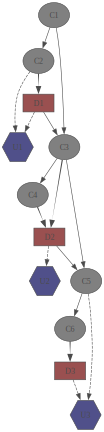

In [24]:
gnb.showInfluenceDiagram(test_id)

In [26]:
test_id.saveBIFXML('figure_2.bifxml')